In [1]:
!wget -c http://benchmark.ini.rub.de/Dataset_GTSDB/FullIJCNN2013.zip
!unzip FullIJCNN2013.zip

--2019-03-22 10:12:28--  http://benchmark.ini.rub.de/Dataset_GTSDB/FullIJCNN2013.zip
Resolving benchmark.ini.rub.de (benchmark.ini.rub.de)... 134.147.122.15
Connecting to benchmark.ini.rub.de (benchmark.ini.rub.de)|134.147.122.15|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  FullIJCNN2013.zip
replace FullIJCNN2013/00000.ppm? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
import numpy as np
import cv2

IMG_HEIGHT = 600
SIGN_SIZE = (224, 224)

# Function for reading the images
def readImages(rootpath, images_range, signs_range):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    data = np.genfromtxt(rootpath + '/' + 'gt.txt', delimiter=';', dtype=str, usecols=range(0, 6))
    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        sign_resized = cv2.resize(sign, SIGN_SIZE)
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels

In [0]:
# The German Traffic Sign Recognition Benchmark
train_images, train_files, train_signs, train_bboxes, train_labels = readImages('FullIJCNN2013', range(0,600), range(0,852))
test_images, test_files, test_signs, test_bboxes, test_labels = readImages('FullIJCNN2013', range(600,900), range(852,1213))

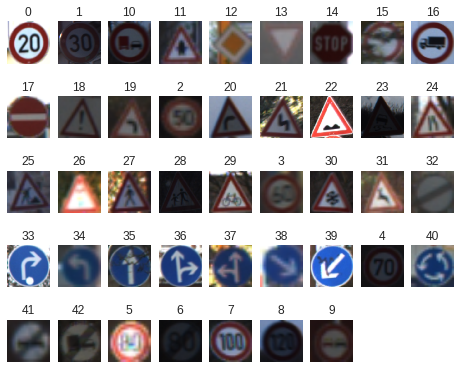

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Show examples from each class
class_names = np.unique(train_labels)
num_classes = len(class_names)
fig = plt.figure(figsize=(8,8))
for i in range(num_classes):
    ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    indices = np.where(np.isin(train_labels, class_names[i]))[0]
    plt.imshow(cv2.cvtColor(train_signs[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
from sklearn.utils import shuffle
train_files, train_signs, train_bboxes, train_labels = shuffle(train_files, train_signs, train_bboxes, train_labels)
# plt.imshow(cv2.cvtColor(train_images.get(train_files[0])[0], cv2.COLOR_BGR2RGB))
# plt.show()
# plt.imshow(cv2.cvtColor(train_signs[0], cv2.COLOR_BGR2RGB))
# plt.show()
# print(train_bboxes[0])
# print(train_labels[0])

# Data pre-processing
tr_signs = np.array(train_signs)[0:600]
tr_labels = np.array(train_labels)[0:600]
va_signs = np.array(train_signs)[600:852]
va_labels = np.array(train_labels)[600:852]
te_signs = np.array(test_signs)
te_labels = np.array(test_labels)

tr_signs = tr_signs.astype('float32')
va_signs = va_signs.astype('float32')
te_signs = te_signs.astype('float32')
tr_signs /= 255.0
va_signs /= 255.0
te_signs /= 255.0

from keras.utils import np_utils
tr_labels = np_utils.to_categorical(tr_labels, num_classes)
va_labels = np_utils.to_categorical(va_labels, num_classes)
te_labels = np_utils.to_categorical(te_labels, num_classes)

Using TensorFlow backend.


In [0]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras import optimizers

mlp = Sequential()
mlp.add(Dense(8, input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3)))
mlp.add(Flatten())
mlp.add(Activation('relu'))
mlp.add(Dropout(0.2))
mlp.add(Dense(num_classes))
mlp.add(Activation('softmax'))

opt = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
mlp.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
mlp.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 224, 224, 8)       32        
_________________________________________________________________
flatten_1 (Flatten)          (None, 401408)            0         
_________________________________________________________________
activation_1 (Activation)    (None, 401408)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 401408)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 43)                17260587  
_________________________________________________________________
activation_2 (Activat

In [9]:
data = mlp.fit(tr_signs, tr_labels, batch_size=16, epochs=50, verbose=2, validation_data=(va_signs, va_labels), callbacks=[tensorboard])

start = time()
loss, acc = mlp.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('MLP took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

Instructions for updating:
Use tf.cast instead.
Train on 600 samples, validate on 252 samples
Epoch 1/50
 - 14s - loss: 5.1065 - acc: 0.2000 - val_loss: 2.7309 - val_acc: 0.3254
Epoch 2/50
 - 13s - loss: 2.3397 - acc: 0.3883 - val_loss: 2.1669 - val_acc: 0.3889
Epoch 3/50
 - 14s - loss: 1.8803 - acc: 0.4650 - val_loss: 1.9289 - val_acc: 0.4802
Epoch 4/50
 - 13s - loss: 1.6358 - acc: 0.5333 - val_loss: 1.8054 - val_acc: 0.5000
Epoch 5/50
 - 13s - loss: 1.4167 - acc: 0.6017 - val_loss: 1.6627 - val_acc: 0.5079
Epoch 6/50
 - 14s - loss: 1.2499 - acc: 0.6517 - val_loss: 1.5387 - val_acc: 0.5635
Epoch 7/50
 - 13s - loss: 1.0676 - acc: 0.6850 - val_loss: 1.6533 - val_acc: 0.5198
Epoch 8/50
 - 13s - loss: 0.9583 - acc: 0.7317 - val_loss: 1.4771 - val_acc: 0.5952
Epoch 9/50
 - 14s - loss: 0.7834 - acc: 0.7800 - val_loss: 1.5749 - val_acc: 0.5754
Epoch 10/50
 - 13s - loss: 0.7682 - acc: 0.7967 - val_loss: 1.3580 - val_acc: 0.6310
Epoch 11/50
 - 13s - loss: 0.6031 - acc: 0.8383 - val_loss: 1.394